# Introduction

Image detection is a good entry point for learning about the use of neural networks, which I aim to learn more about in this project. The problem to be solved in my project is image detection (of handwritten digits, in this case) by using the branch of machine learning that deals with image detection. 

# Data Wrangling

I'll first read in the data and then check for any anomalies. The data exists, among other places, in a scikit-learn repository through Python, where I'll access it for convenience. I'll follow a sample approach provided on this site: http://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html#sphx-glr-auto-examples-linear-model-plot-sparse-logistic-regression-mnist-py. Because the dataset here has already been compiled and split into an X matrix (functioning as predictor variables) and a y vector (serving as a dependent variable), no preprocessing is needed. In most real-world analyses, preprocessing would be needed, however.

In [2]:
%matplotlib inline
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict

mnist = fetch_mldata('MNIST original')
X = mnist.data.astype('float64') #create floats for indications of percent greyness in each image's pixels
y = mnist.target

The dataset's observations have two components. The first is the initial image of a handwritten digit, which exists as an image of 28x28 pixels. Each image has been "flattened" into a 28x28 design matrix with 784 total values. Each value (0, .1, ..., .9) indicates how filled that pixel is by handwriting, with higher values indicating darker marks. Together, the amounts and locations of fill create an image of the handwritten digit. (See the following link for a sample image and visual aid: https://www.tensorflow.org/get_started/mnist/beginners.) The collection of 70,000 such matrices forms the X matrix read in above. 

The other piece of each observations is the correct label for each handwritten digit. These labels form a vector of 70,000 digits/labels, read in as y above.

The code below confirms these dimensions.

In [3]:
print(X.shape) 
print(y.shape) 
print(np.unique(y))

(70000, 784)
(70000,)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]


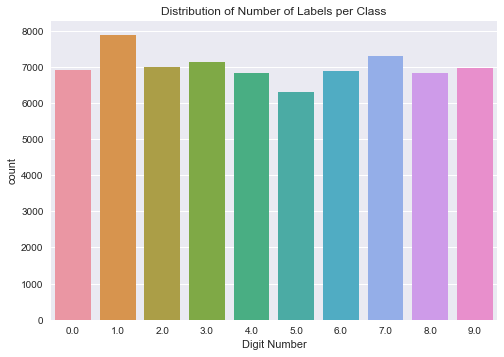

In [4]:
# bar plot for vector y
sns.countplot(y)
plt.title('Distribution of Number of Labels per Class')
plt.xlabel('Digit Number')
plt.show()

The bar plot above shows that the digits are very close to uniform in their frequency, based on their distribution in the vector y. This bodes well for analysis because we won't have to adjust algorithms to deal with imbalanced data in the vector serving as the dependent variable.

In [8]:
import sklearn

# Model Building and Analysis: Logistic Regression

As a baseline comparison to the coming neural network, I will first run a logistic regression. We can use the results here to compare performance against that of the neural network. Logistic regression is commonly used in binary classification problems but can also be used for multinomial ones like this one, in which we are attempting to classify multiple digits. It works by identifying features that have the greatest predictive value (mathematically) on the outcome of interest. 

To start, I will split the data into training and test sets. The training set will be used for model building, with the test data set aside in advance to evaluate how well the model then generalizes. I'll also scale the data using standard scaling, which sets a mean of zero and a variance of one unit. This step makes computations more stable. 

In [4]:
from sklearn.preprocessing import StandardScaler

# train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

# standard scaling (mean of zero, unit variance) 
scaler = StandardScaler(with_mean = False) #with_mean parameter accommodates sparse matrices 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Next, I will run an initial model with tuned parameters. The L1 penalty sometimes performs better than the L2 with sparse matrices, but frankly, I have not been able to get Python to acknowledge the "saga" solved that is supposed to work in conjunction with L1. (An error message appears saying that saga isn't an option for logistic regression, despite the documentation suggesting otherwise.) As a secondary option, I will use the "sag" solver with L2 regularization, which is another acceptable pairing for multinomial classifications. 

I will also tweak the tolerance (tol in the code) in the model, which expedites the convergence of the algorithm with a large amount of data like we have here. The default tolerance is .0001, so we don't want to deviate too far from that, or the model may not generalize well. 

In [5]:
# logistic regression on training data -- note: computationally intensive

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

C_grid = {'C': [0.001, 0.1, 1, 10, 100]}
clf_grid = GridSearchCV(LogisticRegression(multi_class='multinomial', solver='sag', tol=.01, penalty='l2'), 
                        C_grid, cv = 5, scoring = 'accuracy')
clf_grid.fit(X_train, y_train)
print(clf_grid.best_params_, clf_grid.best_score_)

{'C': 10} 0.919232142857


In [6]:
 #check performance on test set
clf_grid_test = LogisticRegression(C = clf_grid.best_params_['C'], multi_class='multinomial', solver='sag', tol=0.1)
clf_grid_test.fit(X_train, y_train)
accuracy_score(clf_grid_test.predict(X_test), y_test)

0.88078571428571428

For a more granular look at the model's performance on the test data, a classification report will show how well it predicted each digit. The aggregate accuracy score above and the metrics below indicate a strong model overall, as precision and recall are both well above .5 (the equivalent of random guessing) for each digit. 

For comparison, the next table shows digit-level performance for the training data. As expected, the model performs a bit better here, but not so much as to indicate overfitting. 

In [7]:
# report for training data
print(classification_report(clf_grid_test.predict(X_train), y_train))

             precision    recall  f1-score   support

        0.0       0.95      0.94      0.94      5607
        1.0       0.96      0.92      0.94      6639
        2.0       0.86      0.89      0.87      5394
        3.0       0.87      0.86      0.86      5773
        4.0       0.90      0.90      0.90      5513
        5.0       0.79      0.86      0.82      4674
        6.0       0.93      0.91      0.92      5619
        7.0       0.89      0.91      0.90      5664
        8.0       0.82      0.82      0.82      5391
        9.0       0.87      0.84      0.86      5726

avg / total       0.89      0.89      0.89     56000



In [8]:
# report for test data
print(classification_report(clf_grid_test.predict(X_test), y_test))

             precision    recall  f1-score   support

        0.0       0.94      0.94      0.94      1351
        1.0       0.96      0.91      0.94      1628
        2.0       0.85      0.89      0.87      1348
        3.0       0.86      0.84      0.85      1428
        4.0       0.91      0.89      0.90      1367
        5.0       0.78      0.86      0.82      1137
        6.0       0.93      0.91      0.92      1395
        7.0       0.89      0.91      0.90      1445
        8.0       0.81      0.81      0.81      1458
        9.0       0.87      0.84      0.86      1443

avg / total       0.88      0.88      0.88     14000



Finally, we'll look at a heat map to visualize the performance of the model. The heat map is based on a confusion matrix, which captures the predicted-actual pairings for each digit. Each row/column represents a digit, in order from zero to nine. 

In [9]:
# confusion matrix for each digit 
y_pred = clf_grid_test.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1264    0   11    7    5   17   15    2   24    6]
 [   0 1486   12   11    1    6    4    5   20    3]
 [  11   13 1199   24   27    4   43   27   56    4]
 [   6   13   43 1203    1   46    7   23   40   15]
 [   0   12   12    1 1222    2   14    4   12   71]
 [  20   11    7   74   19  973   30    8   80   21]
 [  13   10   24    1    5   20 1272    0   29    0]
 [   5   25   11    8   23    4    1 1317    6   75]
 [  14   49   23   69    8   58    9   13 1182   35]
 [  18    9    6   30   56    7    0   46    9 1213]]


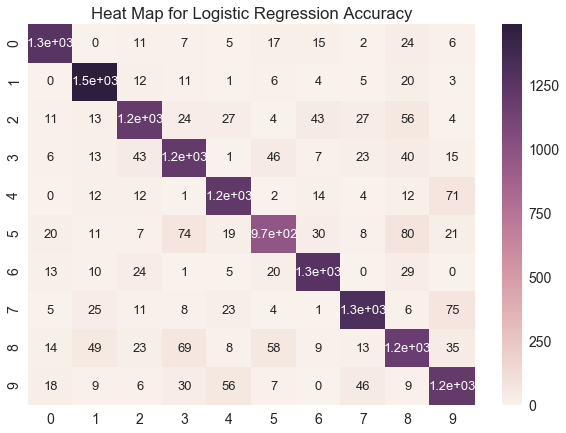

In [10]:
# heat map 
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #set label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 13}) #set font size
plt.title('Heat Map for Logistic Regression Accuracy')
plt.show() 

# Model Building and Analysis: Random Forest

For an additional comparison to the coming neural network, I will create a random forest. The structure of this model is notably different from a logistic regression, so its output will be valuable for comparison to the neural network as well. In particular, the random forest makes classification decisions based on a decision trees that rely on series of split points (e.g., where to draw the line between a 2 and a 3) of the different variables. The random forest randomly generates many decision trees to harness the benefits of an ensemble model. 

In [11]:
# build/fit model with random forest 
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(random_state = 17) 
model_rf = clf_rf.fit(X_train, y_train)

In [12]:
# model accuracy on test data
print(model_rf.score(X_test, y_test))

0.943642857143


In [13]:
# classification report
print(classification_report(clf_rf.predict(X_test), y_test))

             precision    recall  f1-score   support

        0.0       0.98      0.96      0.97      1386
        1.0       0.98      0.97      0.98      1559
        2.0       0.96      0.93      0.94      1440
        3.0       0.93      0.90      0.92      1440
        4.0       0.95      0.93      0.94      1382
        5.0       0.92      0.93      0.93      1225
        6.0       0.97      0.97      0.97      1377
        7.0       0.95      0.96      0.95      1470
        8.0       0.88      0.94      0.91      1370
        9.0       0.91      0.94      0.92      1351

avg / total       0.94      0.94      0.94     14000



To improve the model's stability and ability to generalize, I will work on tuning the parameters of the random forest algorithm. This step will help determine the optimal method for using the maximum number of features without overfitting. The performance metrics may drop some in turn, but it's a worthwhile trade-off to help the model generalize effectively. 

In [30]:
# updated random forest model 
new_rf = RandomForestClassifier(random_state = 64, n_estimators = 20, max_features = 'sqrt', max_depth = 5)
new_clf = new_rf.fit(X_train, y_train)

# accuracy score and classification report with respect to test data                               
print(new_clf.score(X_test, y_test))
print(classification_report(new_clf.predict(X_test), y_test))

0.834357142857
             precision    recall  f1-score   support

        0.0       0.93      0.90      0.92      1403
        1.0       0.97      0.84      0.90      1794
        2.0       0.83      0.86      0.84      1357
        3.0       0.85      0.74      0.79      1602
        4.0       0.82      0.83      0.82      1342
        5.0       0.64      0.90      0.75       882
        6.0       0.88      0.86      0.87      1408
        7.0       0.89      0.82      0.86      1603
        8.0       0.72      0.84      0.78      1251
        9.0       0.77      0.79      0.78      1358

avg / total       0.85      0.83      0.84     14000



Through some quick trial and error, I determined that using both the square root and log2 options for the max_features parameter produce nearly the same results, which makes sense mathematically for 10 features. I'll leave the default of square root in place for this parameter. For the number of estimators (or trees), I tested 10, 20, and 30, which all produced similar results. With a relatively small number of features, 20 seems like a good middle ground to limit error while still having enough randomization in the ensemble. Model performance also held with a depth of 5 levels in the trees, so I will keep this relatively low value to reduce the potential for overfitting. 

In [31]:
# confusion matrix for each digit 
y_pred_rf = new_clf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)

[[1260    0    1   12    2    7   25    2   40    2]
 [   0 1506    7    9    3    3    3   10    4    3]
 [  17   49 1168   40   16    1   42   47   25    3]
 [  14   33   47 1188    8   27    5   34   19   22]
 [  10    7   13    3 1108    4   45   35   22  103]
 [  44   35   12  200   26  792   43   29   28   34]
 [  32   25   38   10    8   20 1215    6   20    0]
 [   4   30   24   10   35    1    0 1318   16   37]
 [   3  101   40  105   21   20   22   12 1054   82]
 [  19    8    7   25  115    7    8  110   23 1072]]


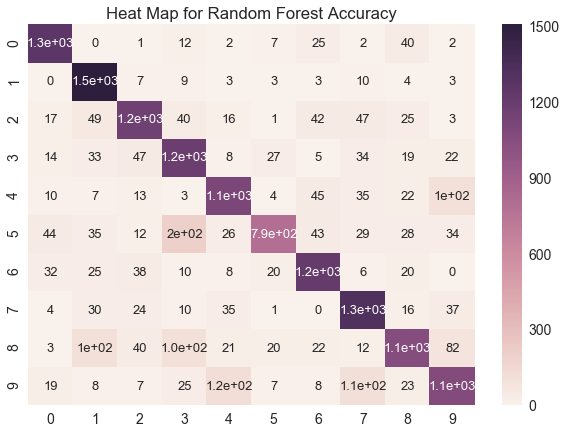

In [32]:
# heat map 
df_rf = pd.DataFrame(cm_rf)
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) 
sns.heatmap(df_rf, annot=True, annot_kws={"size": 13}) 
plt.title('Heat Map for Random Forest Accuracy')
plt.show() 

The logistic-regression model outperforms the random forest based on accuracy scores and the confusion matrix. In examining the neural network, which I'll proceed with now, the logistic regression will be the more "competitive" model. 

# Model Building and Analysis: Neural Network

For parameters, I'll start with 'adam' as the solver because I understand it to be a good compromise of computational demand and advanced weighting. (It is also the default in scikit-learn.) I will use the logistic activation function as well. It often performs better in classification problems because small changes in variable weights and bias cause only a small change in its output. Finally, to determine the best alpha value (L2 regularization penalty), I will use cross-validation. The L2 penalty is important for striking the right balance between variance and bias so that the model will generalize appropriately. 

The multi-layer perceptron network has three layers of perceptrons to process the data. The first layer, the input layer, has 784 cells/perceptrons (one for each feature/image in X) and is activated by the inputs of X. These inputs are also called activation units. The second, middle layer is the hidden layer. It is activated by a linear combination of the activation units in the input layer. For a relatively basic network like this one, I leave the default setting of 100 cells in place. The third and final layer is the output layer, which is activated by a linear combination of activation units in the hidden layer. The output layer has 10 cells, one for each digit of handwriting. 

In [18]:
# cross-validation to choose best alpha -- note: computationally intensive
from sklearn.neural_network import MLPClassifier

alphas = {'alpha': [0.0001, 0.001, 0.01, 0.1]}
mlp_grid = GridSearchCV(MLPClassifier(solver='adam', activation='logistic', random_state=1), 
                        alphas, cv = 5, scoring = 'accuracy')
mlp_grid.fit(X_train, y_train)
print(mlp_grid.best_params_, mlp_grid.best_score_)

{'alpha': 0.01} 0.969107142857


In [19]:
# neural network model with best alpha
mlp = MLPClassifier(solver='adam', alpha=.01, activation='logistic', random_state=1)
mlp.fit(X, y)
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

Training set score: 0.940232
Test set score: 0.936214


In [20]:
# classification report for training data
print(classification_report(mlp.predict(X_train), y_train))

             precision    recall  f1-score   support

        0.0       0.97      0.98      0.97      5482
        1.0       0.97      0.98      0.98      6271
        2.0       0.95      0.90      0.93      5910
        3.0       0.95      0.91      0.93      6000
        4.0       0.88      0.98      0.93      4906
        5.0       0.94      0.89      0.91      5361
        6.0       0.96      0.95      0.95      5547
        7.0       0.97      0.94      0.95      5967
        8.0       0.87      0.95      0.91      4929
        9.0       0.93      0.92      0.93      5627

avg / total       0.94      0.94      0.94     56000



In [21]:
# classification report for test data
print(classification_report(mlp.predict(X_test), y_test))

             precision    recall  f1-score   support

        0.0       0.96      0.97      0.96      1333
        1.0       0.97      0.99      0.98      1526
        2.0       0.95      0.90      0.93      1492
        3.0       0.95      0.90      0.92      1480
        4.0       0.87      0.98      0.93      1201
        5.0       0.94      0.88      0.91      1320
        6.0       0.96      0.95      0.96      1397
        7.0       0.97      0.94      0.95      1520
        8.0       0.86      0.95      0.90      1330
        9.0       0.92      0.92      0.92      1401

avg / total       0.94      0.94      0.94     14000



In [22]:
# confusion matrix for each digit 
y_pred_mlp = mlp.predict(X_test)
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
print(cm_mlp)

[[1291    0   17   11    1    6   13    2   10    0]
 [   1 1507    8    7    1    5    2    4    9    4]
 [   4    2 1342   14    2    2   12   12   16    2]
 [   2    0   26 1325    2   17    3    8   12    2]
 [   0    4   23    8 1180   12   27   16    8   72]
 [  10    0   13   37    1 1163   11    3    3    2]
 [   7    0   22    1    0   19 1324    0    1    0]
 [   1    4    8   10    1    4    0 1428    0   19]
 [  10    6   30   47    1   76    5    8 1262   15]
 [   7    3    3   20   12   16    0   39    9 1285]]


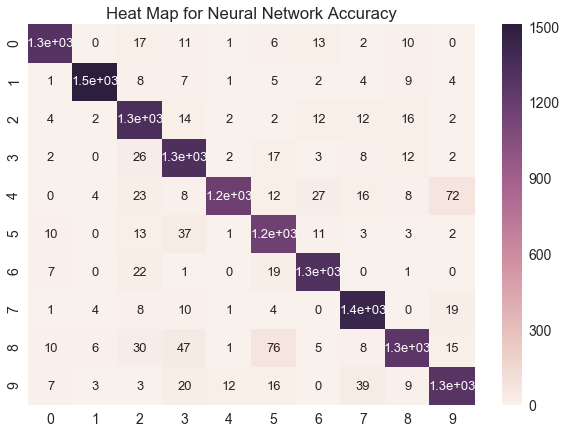

In [23]:
# heat map for neural network
df_mlp = pd.DataFrame(cm_mlp)
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) 
sns.heatmap(df_mlp, annot=True, annot_kws={"size": 13}) 
plt.title('Heat Map for Neural Network Accuracy')
plt.show() 

The classification reports indicate that the neural network outperforms both the logistic regression and the random forest. The overall accuracy for the neural network is several percentage points higher than are the scores of the other two models, and its confusion matrix / heat map show much improvement on individual digits, including 5, which seems to be the hardest digit to read. 